In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Dropout
import random

np.random.seed(42)

In [2]:
df = pd.read_csv('D:\proand\data\ingredient.csv')

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['ingredients'])
encoded_ingredients = tokenizer.texts_to_sequences(df['ingredients'])
max_length = max([len(seq) for seq in encoded_ingredients])
padded_ingredients = pad_sequences(encoded_ingredients, maxlen=max_length, padding='post')

In [4]:
label_encoder = LabelEncoder()
ratings_encoded = label_encoder.fit_transform(df['rating'])


In [5]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_ingredients, ratings_encoded, test_size=0.2, random_state=42)

# Fetch corresponding ratings for training samples
rating_train = df['rating'].iloc[y_train].values.reshape(-1, 1)


In [6]:
# Function to perform word dropout
def word_dropout(sentence, dropout_prob=0.1):
    if isinstance(sentence, str):  # If sentence is a string
        words = sentence.split()
        new_words = [word for word in words if random.random() > dropout_prob]
        if not new_words:  # Check if the list of new words is empty
            return sentence  # Return the original sentence if all words are dropped out
        else:
            return ' '.join(new_words)
    elif isinstance(sentence, np.ndarray):  # If sentence is a NumPy array
        new_sentences = []
        for s in sentence:
            new_sentences.append(word_dropout(s, dropout_prob))
        return np.array(new_sentences)
    elif isinstance(sentence, int):  # If sentence is an integer
        return sentence  # Return the integer as it is
    else:
        return sentence  # Return the original sentence if it's neither a string nor a NumPy array

# Augment training data with word dropout
augmented_X_train = word_dropout(X_train)

In [7]:
# Augment training data with word dropout
augmented_X_train = [str(sentence) for sentence in X_train]  # Convert non-string elements to strings
augmented_X_train = word_dropout(augmented_X_train)

# Tokenize and pad augmented training data
encoded_augmented_X_train = tokenizer.texts_to_sequences(augmented_X_train)
padded_augmented_X_train = pad_sequences(encoded_augmented_X_train, maxlen=max_length, padding='post')

In [10]:
# Model Architecture
num_words = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_dim = 100  # Dimension of word embeddings
num_classes = len(label_encoder.classes_)  # Number of unique ratings

title_input = Input(shape=(max_length,), name='title_input')
rating_input = Input(shape=(1,), name='rating_input')
ingredients_input = Input(shape=(max_length,), name='ingredients_input')

embedding_layer = Embedding(input_dim=num_words, output_dim=embedding_dim)(title_input)
lstm_layer1 = LSTM(128, return_sequences=True)(embedding_layer)
dropout_layer1 = Dropout(0.5)(lstm_layer1)

lstm_layer2 = LSTM(64)(dropout_layer1)
dropout_layer2 = Dropout(0.5)(lstm_layer2)

concat_layer = Concatenate()([dropout_layer2, rating_input, ingredients_input])
dense_layer1 = Dense(128, activation='softmax')(concat_layer)
dropout_layer3 = Dropout(0.5)(dense_layer1)

output_layer = Dense(num_classes, activation='softmax')(dropout_layer3)

model = Model(inputs=[title_input, rating_input, ingredients_input], outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Epoch 1/300
4/4 [==============================] - 7s 501ms/step - loss: 1.9365 - accuracy: 0.2991 - val_loss: 1.9316 - val_accuracy: 0.3571
Epoch 2/300
4/4 [==============================] - 0s 66ms/step - loss: 1.9295 - accuracy: 0.3504 - val_loss: 1.9244 - val_accuracy: 0.3571
Epoch 3/300
4/4 [==============================] - 0s 54ms/step - loss: 1.9233 - accuracy: 0.2650 - val_loss: 1.9144 - val_accuracy: 0.3571
Epoch 4/300
4/4 [==============================] - 0s 44ms/step - loss: 1.9144 - accuracy: 0.2650 - val_loss: 1.9010 - val_accuracy: 0.3571
Epoch 5/300
4/4 [==============================] - 0s 46ms/step - loss: 1.8985 - accuracy: 0.3333 - val_loss: 1.8892 - val_accuracy: 0.3571
Epoch 6/300
4/4 [==============================] - 0s 63ms/step - loss: 1.8866 - accuracy: 0.2991 - val_loss: 1.8779 - val_accuracy: 0.3571
Epoch 7/300
4/4 [==============================] - 0s 46ms/step - loss: 1.8807 - accuracy: 0.3333 - val_loss: 1.8672 - val_accuracy: 0.3571
Epoch 8/300
4/4 [==

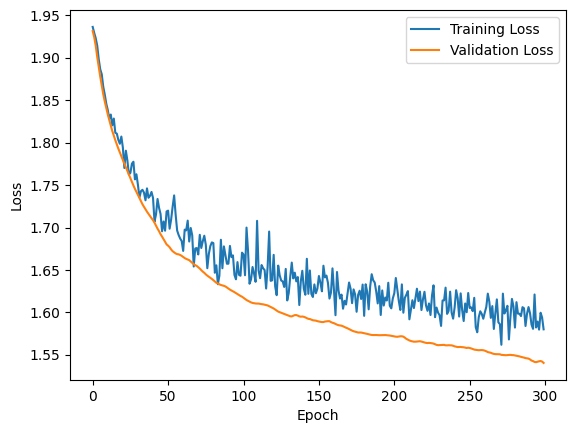

In [11]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir="logs/fit")

# Train the model using augmented data
history = model.fit(
    x=[padded_augmented_X_train, rating_train, padded_augmented_X_train],
    y=y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, tensorboard_callback]
)
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [96]:
model.save('model.h5')

d:\proand\env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
